In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [3]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [4]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [5]:
metrics = ["gm_vol","adc","fa","ad","rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})



# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1763869/2081395043.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_1763869/2081395043.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_1763869/2081395043.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_1763869/2081395043.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykerne

In [6]:
metric_cols = {metric: "volume" if metric == "gm_vol" else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df


In [7]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [8]:
import numpy as np
import pandas as pd


# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)  # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values)[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,  # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)  # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)  # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),  # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w

In [9]:
# assign weights
for metric in metrics:
    data[metric]["weight"], _ = compute_poststrat_weights(
        data[metric],
        israel_population,
        age_col="age_at_scan",
        cap=None,  # try None first; if still spiky, use 4 or 5
        return_bin_table=True,
    )
    data[metric]["subject_code"] = data[metric]["subject_code"].astype(str).str.zfill(4)

In [10]:
# df_long = data["adc"].copy()
# df_long[df_long["subject_code"] == 447]["subject_code"]

In [11]:
import pandas as pd
from functools import reduce


def long_to_wide(
    long_df,
    *,
    index="subject_code",
    columns=region_col,
    values="value",
):
    """Pivot a long metric table → wide DataFrame (subjects × regions)."""
    wide = long_df.pivot_table(
        index=index, columns=columns, values=values, aggfunc="first"
    )
    # Optional: drop regions with >20 % missing values
    thresh = int(0.8 * len(wide))
    wide = wide.dropna(axis=1, thresh=thresh)
    # Optional: drop subejcts with >20 % missing values
    thresh = int(0.8 * len(parcels))
    wide = wide.dropna(axis=0, thresh=thresh)
    return wide


def prep_metric_matrices(metric_dict, *, index="subject_code"):
    """
    Parameters
    ----------
    metric_dict : {metric_name: long_df}
        Each DataFrame must include `subject_id`, `region`, `value`,
        `age_at_scan`, and any covariates you want.
    Returns
    -------
    X_dict : {metric_name: ndarray}
             Wide feature matrices aligned on the *intersection* of subjects.
    y, w, cov_df : Series / ndarray
             Age, weights, and any extra covariates for the same subjects.
    """
    # 1.  Convert every long → wide
    wide_dict = {m: long_to_wide(df) for m, df in metric_dict.items()}

    # 2.  Intersect subject index across all metrics
    common_subs = reduce(pd.Index.intersection, [w.index for w in wide_dict.values()])

    # 3.  Slice & order every matrix
    for m in wide_dict:
        wide_dict[m] = wide_dict[m].loc[common_subs]

    # 4.  Pull y, w, covariates from *any* of the long dfs (they all duplicate)
    ref_long = next(iter(metric_dict.values()))
    ref_meta = (
        ref_long.drop_duplicates(subset=index)  # one row per subject
        .set_index(index)
        .loc[common_subs]
    )
    y = ref_meta["age_at_scan"]
    w = ref_meta.get("weight", pd.Series(1.0, index=common_subs))
    cov = ref_meta[ref_meta.columns.difference(["age_at_scan", "weight"])]

    # 5.  Convert features to numpy (sklearn ready)
    X_dict = {m: wide.to_numpy() for m, wide in wide_dict.items()}
    return X_dict, y.to_numpy(), w.to_numpy(), cov

In [12]:
# -------------------------------------------------------
# Build (X, y, w, cov) once, re-use in every metric loop
# -------------------------------------------------------
X_dict, y, w, cov = prep_metric_matrices(data)
# Example list of covariates you want to *keep* (z-scored later if needed)
cov_names = {
    m: ["sex"] if m != "gm_vol" else ["sex", "tiv"] for m in metrics
}  # e.g. ["sex", "tiv"]

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

def cross_val_predict_with_posthoc(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y: np.ndarray,
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    post_hoc_degree: int = 1,
) -> np.ndarray:
    """
    Cross-validated predictions with OPTIONAL linear / polynomial
    post-hoc bias-correction (fit on training residuals only).

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y                : shape (n_samples,) – chronological age
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored
    post_hoc_degree  : 0 ⇒ no correction; 1 ⇒ linear; 2 ⇒ quadratic …

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    """

    # ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y = np.asarray(y)
    w = np.asarray(w)

    y_oof = np.full_like(y, np.nan, dtype=float)

    original_residuals = np.full_like(y, np.nan, dtype=float)
    corrected_residuals = np.full_like(y, np.nan, dtype=float)

    for train_idx, test_idx in cv.split(X_arr, y):
        X_tr, X_te = X_arr[train_idx], X_arr[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        w_tr = w[train_idx]

        # ---------------- fit base model -----------------------------
        fit_kwargs = {"estimator__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- predict on test fold -----------------------
        y_pred_te = model.predict(X_te)
        y_pred_tr = model.predict(X_tr)
        # ---------------- optional post-hoc bias ---------------------
        if post_hoc_degree > 0:
            orig_resid_te = y_te - y_pred_te
            lin = LinearRegression().fit(y_tr.reshape(-1, 1), y_pred_tr)
            a, b = lin.intercept_, lin.coef_[0]
            y_pred_te = (y_pred_te - a) / b
            original_residuals[test_idx] = orig_resid_te
            corrected_residuals[test_idx] = y_te - y_pred_te
            # resid_tr = y_tr - model.predict(X_tr)
            # coeffs = np.polyfit(y_pred_tr, resid_tr, post_hoc_degree)
            # bias_fn = np.poly1d(coeffs)
            # orig_resid_te = y_te - y_pred_te
            # te_bias = bias_fn(y_pred_te)
            # y_pred_te = y_pred_te + te_bias
            # original_residuals[test_idx] = orig_resid_te
            # corrected_residuals[test_idx] = y_te - y_pred_te
           
        y_oof[test_idx] = y_pred_te

    return y_oof, original_residuals, corrected_residuals

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

def cross_val_predict_with_posthoc(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y: np.ndarray,
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    post_hoc_degree: int = 1,
) -> np.ndarray:
    """
    Cross-validated predictions with OPTIONAL linear / polynomial
    post-hoc bias-correction (fit on training residuals only).

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y                : shape (n_samples,) – chronological age
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored
    post_hoc_degree  : 0 ⇒ no correction; 1 ⇒ linear; 2 ⇒ quadratic …

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    """

    # ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y = np.asarray(y)
    w = np.asarray(w)

    y_oof = np.full_like(y, np.nan, dtype=float)

    original_residuals = np.full_like(y, np.nan, dtype=float)
    corrected_residuals = np.full_like(y, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y):
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)
        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = y[train_idx], y[test_idx], y[val_idx]
        w_tr = w[train_idx]
        w_val = w[val_idx]

        # ---------------- fit base model -----------------------------
        fit_kwargs = {"estimator__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- predict on test fold -----------------------
        y_pred_te = model.predict(X_te)
        y_pred_val = model.predict(X_val)
        y_pred_tr = model.predict(X_tr)
        # ---------------- optional post-hoc bias ---------------------
        if post_hoc_degree > 0:
            orig_resid_te = y_te - y_pred_te
            poly = PolynomialFeatures(degree=post_hoc_degree)
            lin = LinearRegression()
            resid_model = Pipeline([
                # ("poly", poly),
                ("lin", lin)
            ])
            fit_kwargs = {"lin__sample_weight": w_val} if use_weights else {}
            resid_model.fit(y_val.reshape(-1, 1), y_val - y_pred_val)
            # a, b = lin.intercept_, lin.coef_[0]
            # y_pred_te = (y_pred_te - a) / b
            y_pred_te = y_pred_te + resid_model.predict(y_pred_te.reshape(-1, 1))
            original_residuals[test_idx] = orig_resid_te
            corrected_residuals[test_idx] = y_te - y_pred_te
            # resid_tr = y_tr - model.predict(X_tr)
            # coeffs = np.polyfit(y_pred_tr, resid_tr, post_hoc_degree)
            # bias_fn = np.poly1d(coeffs)
            # orig_resid_te = y_te - y_pred_te
            # te_bias = bias_fn(y_pred_te)
            # y_pred_te = y_pred_te + te_bias
            # original_residuals[test_idx] = orig_resid_te
            # corrected_residuals[test_idx] = y_te - y_pred_te
           
        y_oof[test_idx] = y_pred_te

    return y_oof, original_residuals, corrected_residuals

In [15]:
import numpy as np, pandas as pd
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-3, 4, 30)  # ridge λ grid

outer_cv = KFold(
    n_splits=10,
    shuffle=True,
    random_state=1,
)

perf_rows = []

use_weights = True
do_post_hoc_correction = True
post_hoc_degree = 1

predictions = {}

for metric, X in X_dict.items():
    # Optionally concatenate covariates
    covariates = cov_names[metric]
    if cov_names:
        X_model = np.hstack([X, cov[covariates].to_numpy()])
    else:
        X_model = X
    # y_pred = stratified_regression_cv(X_model, y, w, n_splits=10, n_bins=10)

    # # Model & CV (same ridge code as before)
    scaler = StandardScaler()
    estimator = RidgeCV(
        # l1_ratio=[0, 0.5, 0.9, 1.0],
        alphas=alphas,
        # max_iter=int(1e6),
        # scoring="neg_mean_squared_error"
    )
    model = Pipeline([
        ("scaler", scaler),
        ("estimator", estimator),
    ])

    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_posthoc(
        model=model,
        X=X_model,
        y=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
    )

    # y_pred = cross_val_predict(
    #     model,
    #     X_model,
    #     y,
    #     # groups=age_strata(y),
    #     cv=outer_cv,
    #     params={"estimator__sample_weight": w if use_weights else None},
    #     n_jobs=-1,
    # )
    # if do_post_hoc_correction:
    #     resid = y - y_pred
    #     z = np.polyfit(y, resid, 2)
    #     p = np.poly1d(z)
    #     y_pred = y_pred + p(y)
    # # Save predictions
    predictions_df = cov.copy()
    predictions_df["True"] = y
    predictions_df["Predicted"] = y_pred
    predictions_df["raw_residuals"] = original_residuals
    predictions_df["corrected_residuals"] = corrected_residuals
    predictions[metric] = predictions_df
    perf_rows.append(
        dict(
            metric=metric,
            R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
            MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
            RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
        )
    )
    # break

In [16]:
from scipy.stats import spearmanr

spearmanr(predictions["gm_vol"]["True"], predictions["gm_vol"]["corrected_residuals"])


SignificanceResult(statistic=np.float64(0.03267058320329767), pvalue=np.float64(0.12511183762644426))

In [17]:
pd.DataFrame(perf_rows).set_index("metric")

,R2,MAE,RMSE
metric,,,
gm_vol,0.807688,6.567965,8.193023
adc,0.720502,7.583382,9.877122
fa,0.744228,7.181572,9.448590
ad,0.741679,7.119233,9.495555
rd,0.715476,7.493178,9.965527


In [18]:
### ----------- Concatenate all metrics into one model ----------- ###
from sklearn.pipeline import make_pipeline

X_concat = np.hstack([X_dict[m] for m in metrics])  # already row-aligned
# add covariates
covariates = pd.concat([cov[cov_names[m]] for m in metrics], axis=1)
# drop duplicate columns
covariates = covariates.loc[:, ~covariates.columns.duplicated()].to_numpy()
X_concat = np.hstack([X_concat, covariates])
scaler = StandardScaler()
ridgecv = RidgeCV(
    alphas=alphas,
    # max_iter=int(1e6),
    # scoring="neg_mean_squared_error"
)
pipe = Pipeline(
    [
        ("scaler", scaler),
        ("estimator", ridgecv),
    ]
)
y_pred, original_residuals, corrected_residuals = cross_val_predict_with_posthoc(
    model=pipe,
    X=X_concat,
    y=y,
    w=w,
    cv=outer_cv,
    post_hoc_degree=post_hoc_degree,
    use_weights=use_weights,
    # n_jobs=-1,
    # params={"estimator__sample_weight": w if use_weights else None},
)

# if do_post_hoc_correction:
#     resid = y - y_pred
#     z = np.polyfit(y, resid, 2)
#     p = np.poly1d(z)
#     y_pred = y_pred + p(y)
# # Save predictions
predictions_df = cov.copy()
predictions_df["True"] = y
predictions_df["Predicted"] = y_pred
predictions_df["raw_residuals"] = original_residuals
predictions_df["corrected_residuals"] = corrected_residuals
predictions["concatenated"] = predictions_df
perf_rows.append(
    dict(
        metric="concatenated",
        R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
        MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
        RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
    )
)

In [19]:
# polynomial features
from sklearn.preprocessing import PolynomialFeatures
# ---------------------------------------------------------------------
# 2. Parcel-wise base-learner loop
# ---------------------------------------------------------------------
stacked_models = parcels.copy()

stacked_estimators = {}
predictions["base_stacked"] = {}

alphas = np.logspace(-3, 4, 30)  # ridge grid
for i, row in parcels.iterrows():  # i == parcel index (0..453)
    # ------------- build design matrix for parcel i -----------------
    # X_roi : (n_subjects , 5 metrics)
    X_roi = np.hstack([X_dict[m][:, [i]] for m in metrics])

    pipe = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            # ("poly", PolynomialFeatures(degree=2)),
            ("estimator", RidgeCV(alphas=alphas)),
        ]
    )

    # ---------------- fit model & predict --------------------------

    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_posthoc(
        model=pipe,
        X=X_roi,
        y=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
    )

    # ---------------- store predictions & metrics -------------------
    pred_df = cov.copy()
    pred_df["True"] = y
    pred_df["Predicted"] = y_pred
    pred_df["raw_residuals"] = original_residuals
    pred_df["corrected_residuals"] = corrected_residuals
    predictions["base_stacked"][i] = pred_df
    r2 = r2_score(y, y_pred, sample_weight=w if use_weights else None)
    mae = mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None)
    rmse = root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None)

    stacked_models.loc[i, ["R2", "MAE", "RMSE"]] = (r2, mae, rmse)
    stacked_estimators[i] = pipe

<Axes: >

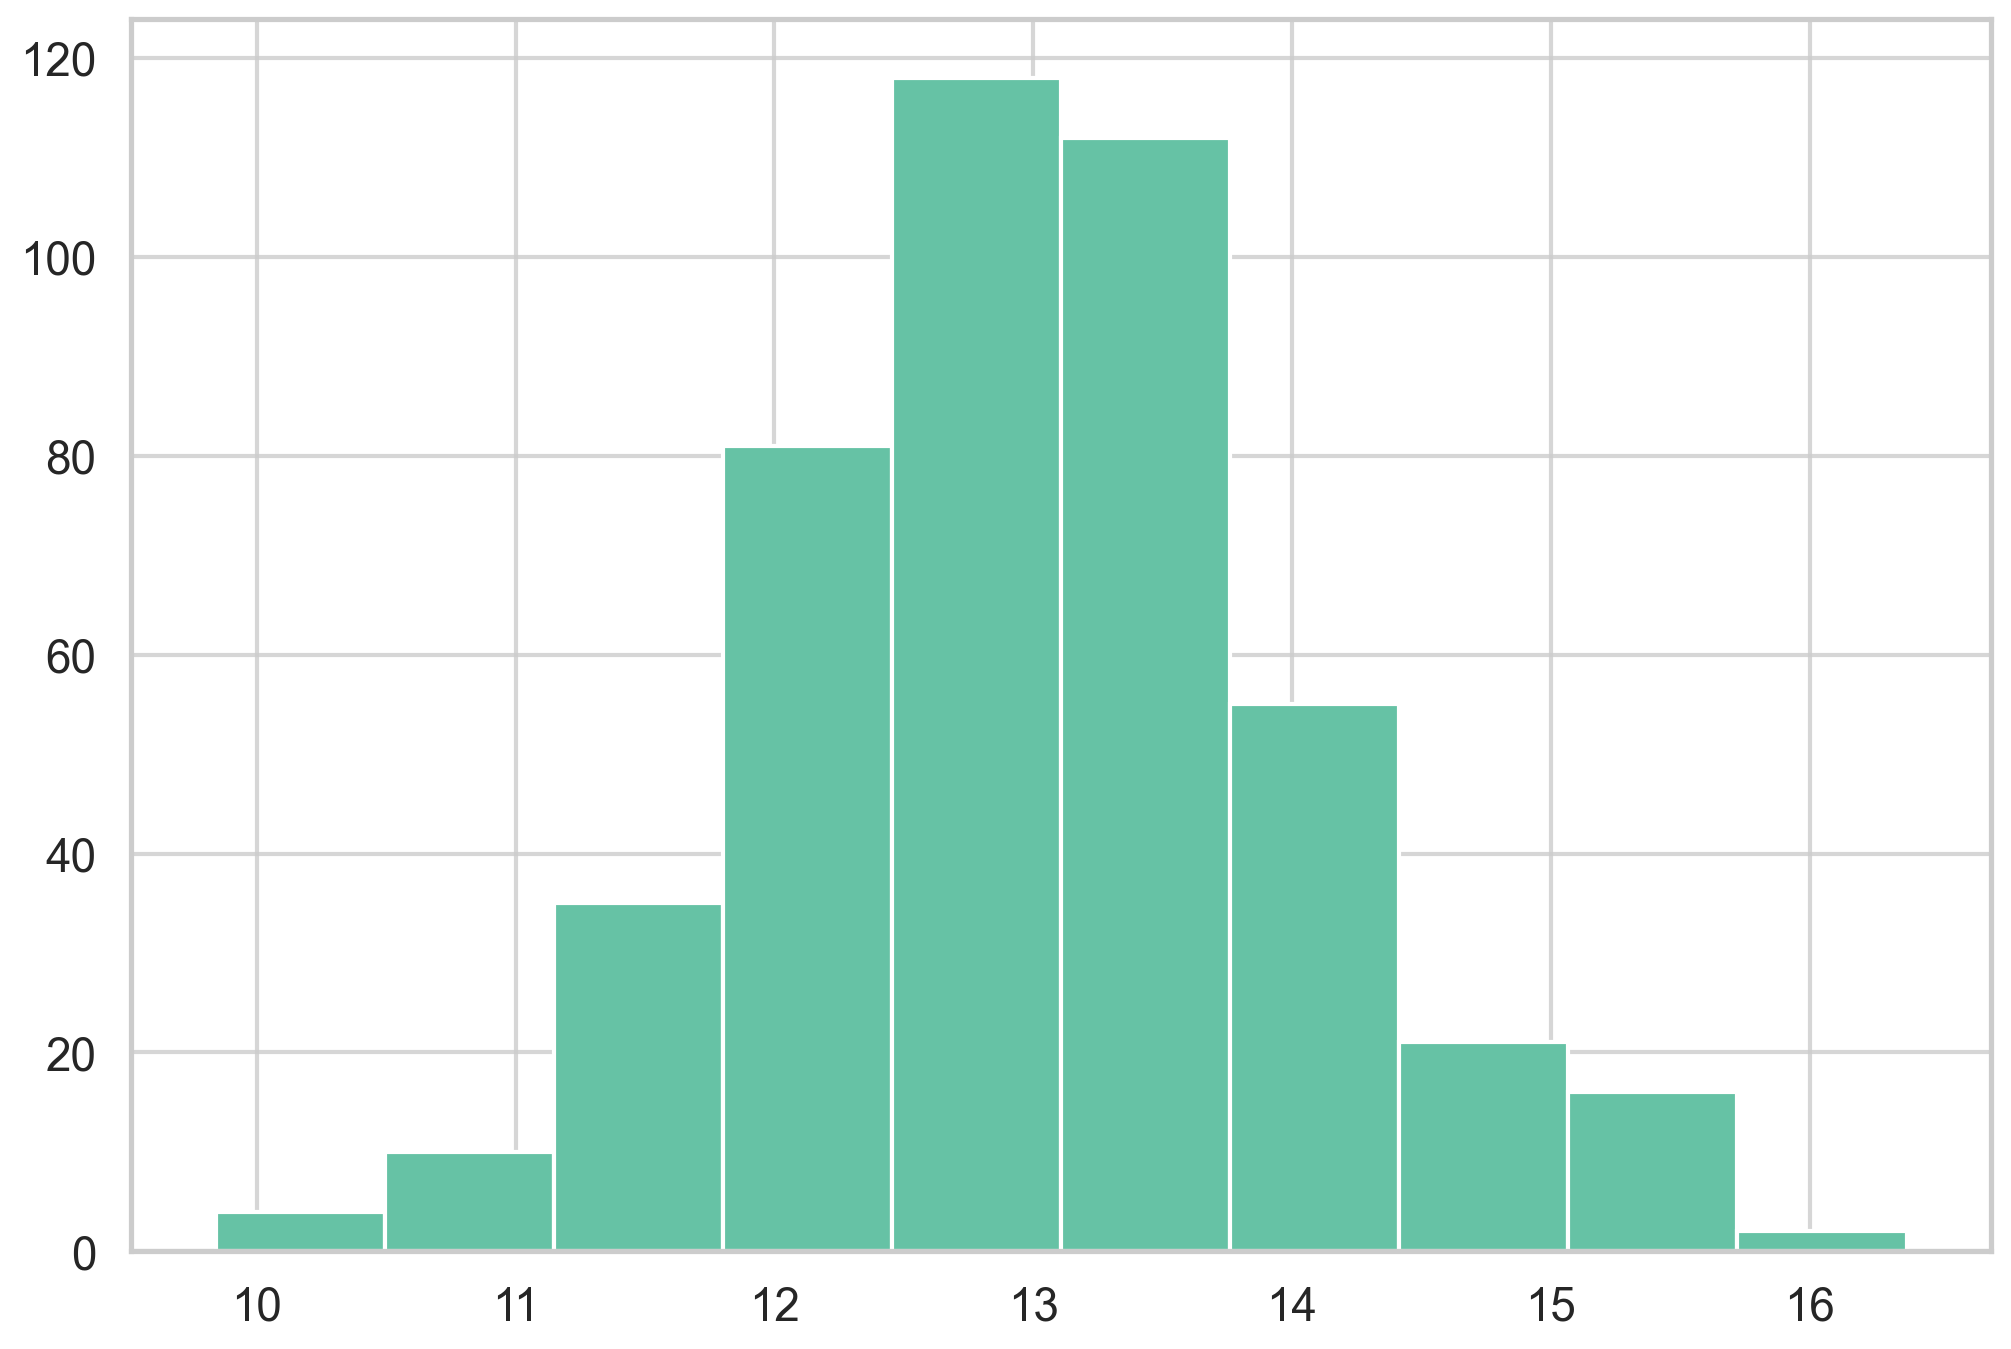

In [20]:
stacked_models["MAE"].hist()

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)

# ------------------------------------------------------------------
# 1.  Build the meta-feature matrix  (n_subj × n_parcels [+ covariates])
# ------------------------------------------------------------------
# stack parcel OOF columns → shape (454, n_subj) → transpose
X_stacked = np.vstack(
    [predictions["base_stacked"][i]["Predicted"].to_numpy() for i in predictions["base_stacked"]]
).T  # (n_subj, n_parcels)

# Optionally add covariates (e.g., sex, TIV)
X_stacked = np.hstack([X_stacked, covariates])

# ------------------------------------------------------------------
# 2.  Meta-learner pipeline (standardised ridge with CV on λ)
# ------------------------------------------------------------------
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", RidgeCV(alphas=alphas)),
    ]
)

# ------------------------------------------------------------------
# 3.  Out-of-fold meta predictions with fold-wise bias correction
# ------------------------------------------------------------------
y_pred, original_residuals, corrected_residuals = cross_val_predict_with_posthoc(
    model=pipe,
    X=X_stacked,
    y=y,
    w=w,
    cv=outer_cv,  # same splitter as base stage
    use_weights=use_weights,
    post_hoc_degree=post_hoc_degree,
)

# ------------------------------------------------------------------
# 4.  Store predictions and performance
# ------------------------------------------------------------------
pred_df = cov.copy()
pred_df["True"] = y
pred_df["Predicted"] = y_pred
pred_df["raw_residuals"] = original_residuals
pred_df["corrected_residuals"] = corrected_residuals
predictions["stacked"] = pred_df


perf_rows.append(
    dict(
        metric="stacked",
        R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
        MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
        RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
    )
)

In [22]:
perf_df = pd.DataFrame(perf_rows).set_index("metric").sort_values("MAE", ascending=True)

/tmp/ipykernel_1763869/1588352906.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="metric",x = "MAE", data=perf_df.reset_index(), palette="Set2", ax=ax, orient="h")


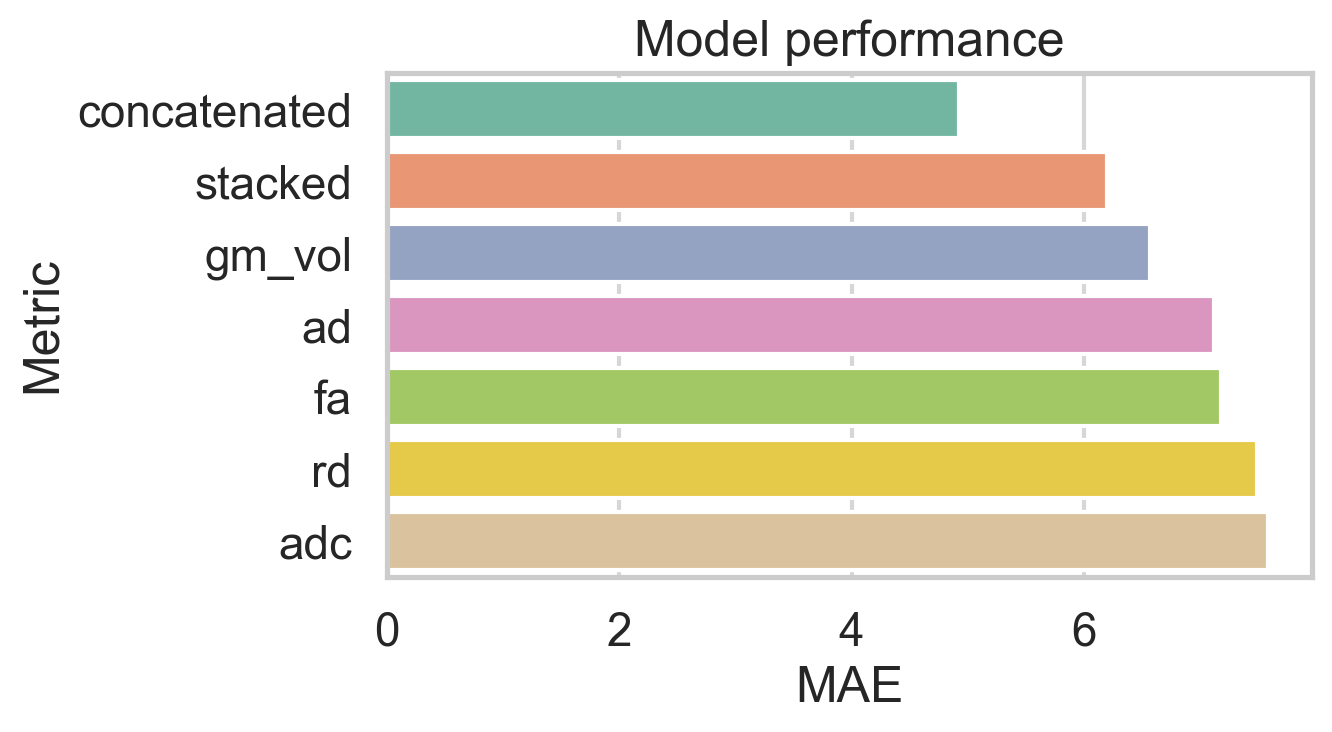

In [23]:
# -----------------------------------------------------------
# 2.  barplot with 95 % BCa bootstrap CIs on R²
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample


# def bca_ci(arr, stat_func=np.mean, n_boot=10000, alpha=0.05):
#     """BCa bootstrap CI for a 1-D array."""
#     boot_stats = [stat_func(resample(arr)) for _ in range(n_boot)]
#     lo, hi = np.percentile(boot_stats, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     return lo, hi


# ci_lo, ci_hi = [], []
# for m in perf_df.index:
#     # resample over subjects to get CI on R²
#     errs = y - X_dict[m].dot(np.ones(X_dict[m].shape[1]))  # dummy just to get shape
#     lo, hi = bca_ci(perf_df.loc[m, ["R2"]].values)
#     ci_lo.append(lo)
#     ci_hi.append(hi)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(y="metric",x = "MAE", data=perf_df.reset_index(), palette="Set2", ax=ax, orient="h")
# ax.errorbar(
#     x=np.arange(len(perf_df)),
#     y=perf_df["RMSE"],
#     # yerr=[perf_df["R2"] - ci_lo, ci_hi - perf_df["R2"]],
#     fmt="none",

#     capsize=4,
#     color="k",
#     lw=1,
# )
# ax.set_ylabel("$R^{2}$  (10× CV, bias-corrected)")
ax.set_xlabel("MAE")
ax.set_ylabel("Metric")
ax.set_title("Model performance")
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_ylim(0.8, perf_df["R2"].max() * 1.15)
plt.tight_layout()
# ax.set_xlim(3,6)
# plt.savefig("metric_comparison_bias_corrected.png", dpi=400)
plt.show()

In [24]:
best_metric = perf_df.index[0]
# best_metric = "gm_vol"
y = predictions[best_metric]["True"].to_numpy()
y_pred = predictions[best_metric]["Predicted"].to_numpy()
# w = predictions[best_metric]["weight"].to_numpy()
df = predictions[best_metric][["True","Predicted"]].copy().rename(columns={"True": "age", "Predicted": "predicted"})

df["residuals"] = df["age"] - df["predicted"]
# # build a model to predict the residuals
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf

# # Fit a linear model to the residuals
# df["residuals"] = residuals
# model = ols("residuals ~ age", data=df).fit()
# # use the model to "fix" the predictions
# df["fixed_predicted"] = df["predicted"] + model.resid

/tmp/ipykernel_1763869/4171841037.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_1763869/4171841037.py:54: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


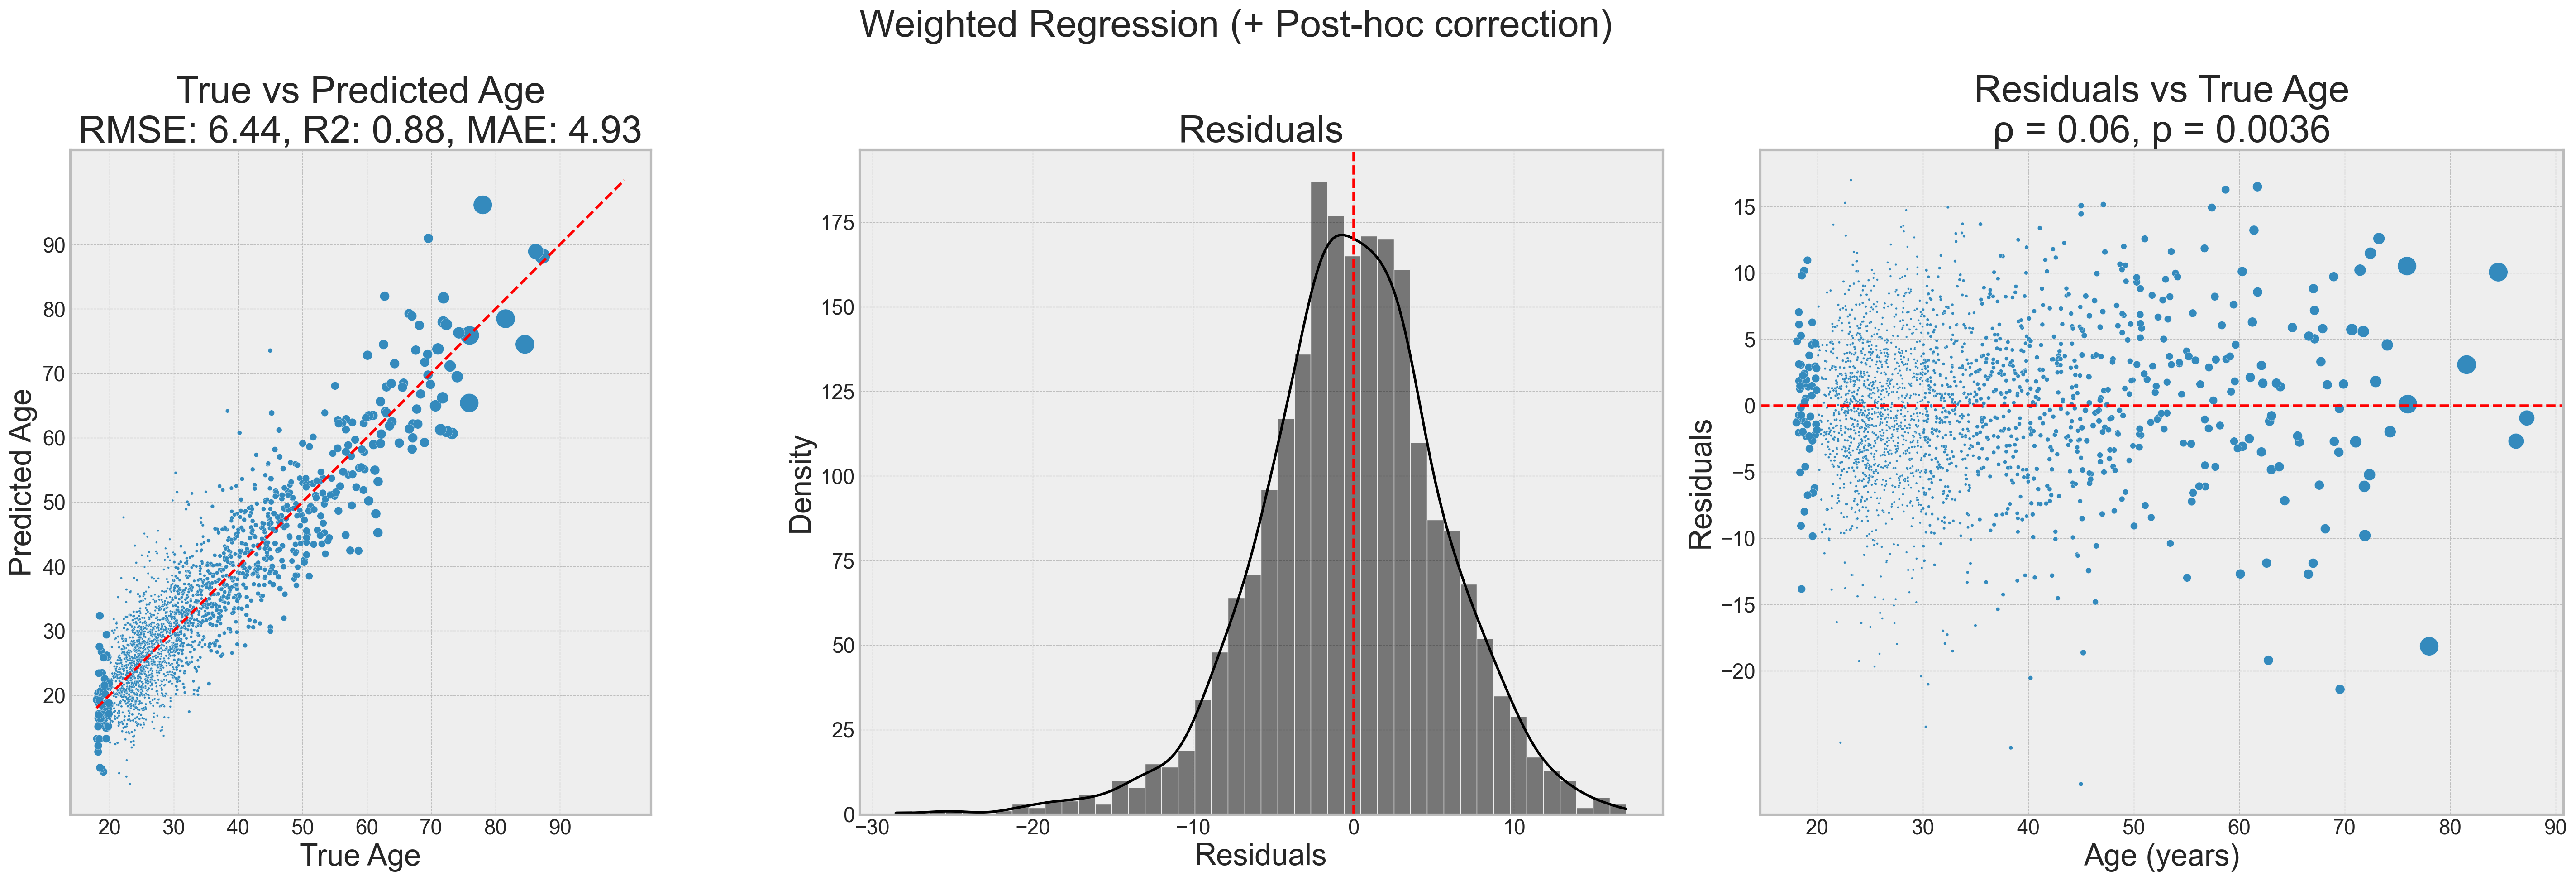

In [25]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

plt.style.use("bmh")


r2 = r2_score(y, y_pred, sample_weight=w if use_weights else None)
rmse = root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None)
mae = mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None)

# r2 = r2_score(y, y_pred)
# rmse = root_mean_squared_error(y, y_pred)
# mae = mean_absolute_error(y, y_pred)


title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}"

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
# plot true vs predicted
ax = axes[0]
sns.scatterplot(
    data=df,
    x="age",
    y="predicted",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    s=w * 10,
)
ax.plot([18, 100], [18, 100], "--", c="red")
ax.set_xlabel("True Age", fontsize=24)
ax.set_ylabel("Predicted Age", fontsize=24)
ax.set_title(title, fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(20, 100, 10))
# make axis square
ax.set_aspect("equal", "box")

# plot residuals
ax = axes[1]
sns.histplot(data=df,x="residuals", ax=ax, kde=True, color="black")
ax.set_xlabel("Residuals", fontsize=24)
ax.set_ylabel("Density", fontsize=24)
ax.set_title("Residuals", fontsize=30)
ax.axvline(0, color="red", linestyle="--")

# plot residuals vs true age

r, p = spearmanr(df["age"], df["residuals"])

ax = axes[2]
sns.scatterplot(
    data=df,
    x="age",
    y="residuals",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    s=w*10,
)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Age (years)", fontsize=24)
ax.set_ylabel("Residuals", fontsize=24)
ax.set_title("Residuals vs True Age\nρ = {:.2f}, p = {:.2g}".format(r, p), fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(-20, 20, 5))
# make axis square

suptitle = "Weighted Regression" if use_weights else "Unweighted Regression"
if do_post_hoc_correction:
    suptitle += " (+ Post-hoc correction)"
fig.suptitle(suptitle, fontsize=30)

plt.tight_layout()

In [26]:
df.sort_values("residuals", ascending=False).head(10)

,age,predicted,residuals
subject_code,,,
BB00776,23.19,6.192337,16.997663
AGN04,61.73,45.231034,16.498966
BB00634,58.71,42.431098,16.278902
BB00817,22.64,7.358074,15.281926
BB00046,47.12,31.965012,15.154988
629R,45.01,29.934386,15.075614
BB00842,32.39,17.435771,14.954229
AGN09,57.41,42.481797,14.928203
0029,28.43,13.693028,14.736972


In [27]:
# df_cov = pd.read_pickle(f"/media/storage/phd/papers/aging/{ATLAS}/gm_vol.pkl").reset_index(
#     drop=True
# )
# df_cov = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
df_cov = pd.read_csv("qV1v.csv")

finished_subjects = (
    pd.read_csv("/media/storage/phd/papers/aging/schaefer2018tian2020_400_7/subjects.csv")
    .values.flatten()
    .tolist()
)
df_cov = df_cov[df_cov["Subject Code"].isin(finished_subjects)]

# df_cov = df_cov.groupby("subject_code").first()
df_cov = df_cov.merge(df, left_on="Subject Code", right_index=True, how="inner")

In [28]:
# # cov_df["timestamp"] =
# df_cov["session_timestamp"] = pd.to_datetime(df_cov["session_id"], format="%Y%m%d%H%M%S")
# df_cov["year"] = df_cov["session_timestamp"].dt.year
# df_cov["month"] = df_cov["session_timestamp"].dt.month
# df_cov["day"] = df_cov["session_timestamp"].dt.day

# df_cov["days_since_start"] = (
#     df_cov["session_timestamp"] - df_cov["session_timestamp"].min()
# ).dt.days


In [38]:
df_cov

,Subject Code,Scanned,Contact Again?,CI - Native Language,CI - Ethnicity,CI - Political Orientation,CI - Religious Orientation,LongCovid,FamiliyDiseaseHistory,BloodSugar,...,Unnamed: 50,Blood Suger,HLI.1,Family Disease,Psychiatric,Medication,Unnamed: 56,age,predicted,residuals
2,0002,Yes,Yes,Polish,Ashkenazi Jew,NaN,NaN,NaN,2.0,Normal,...,No Suffering,16.363636,9.404762,0.836538,54.455446,34.615385,6.250000,67.75,64.443413,3.306587
3,0003,Yes,Yes,Hebrew,Sephardic Jew,NaN,NaN,No,3.0,High,...,Minor Suffering,3.546099,9.327778,0.909871,56.768559,26.609442,6.270386,69.01,71.722408,-2.712408
4,0004,Yes,Yes,Arabic,Sephardic Jew,NaN,NaN,NaN,0.0,Normal,...,Major Suffering,7.189542,9.337719,0.971223,58.736059,33.453237,6.082734,73.25,60.655581,12.594419
5,0005,Yes,Yes,Polish,Ashkenazi Jew,NaN,NaN,No,3.0,Normal,...,Signfican Suffering,6.451613,9.558824,0.988372,56.470588,26.162791,6.058140,87.27,88.205925,-0.935925
7,0007,Yes,NaN,Hebrew,Ashkenazi Jew,NaN,NaN,NaN,1.0,Low,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.01,96.157265,-18.147265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,YA1252,Yes,NaN,Hebrew,Ashkenazi Jew,Left-Wing,Secular,No,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.89,15.866585,6.023415
2231,YA1264,Yes,NaN,Hebrew,Ashkenazi Jew,Left-Wing,Traditional - Not Very Religious,No,0.0,Normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.38,16.900105,1.479895
2232,YA1269,Yes,NaN,Hebrew,Ashkenazi Jew,Center,Secular,Yes,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.53,32.703643,-5.173643
2235,YA1279,NaN,NaN,Russian,Ashkenazi Jew,Center-Left,Secular,LongCovid,1.0,Low,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.06,23.803399,-2.743399


In [49]:
x_col = "PSQI"
y = df_cov[x_col].dropna().astype(float)
x = df_cov["residuals"].loc[y.index]
print(spearmanr(x,y))
print(x.shape)

SignificanceResult(statistic=np.float64(-0.02563554716032954), pvalue=np.float64(0.32781774117525164))
(1459,)


<Axes: xlabel='PSQI', ylabel='residuals'>

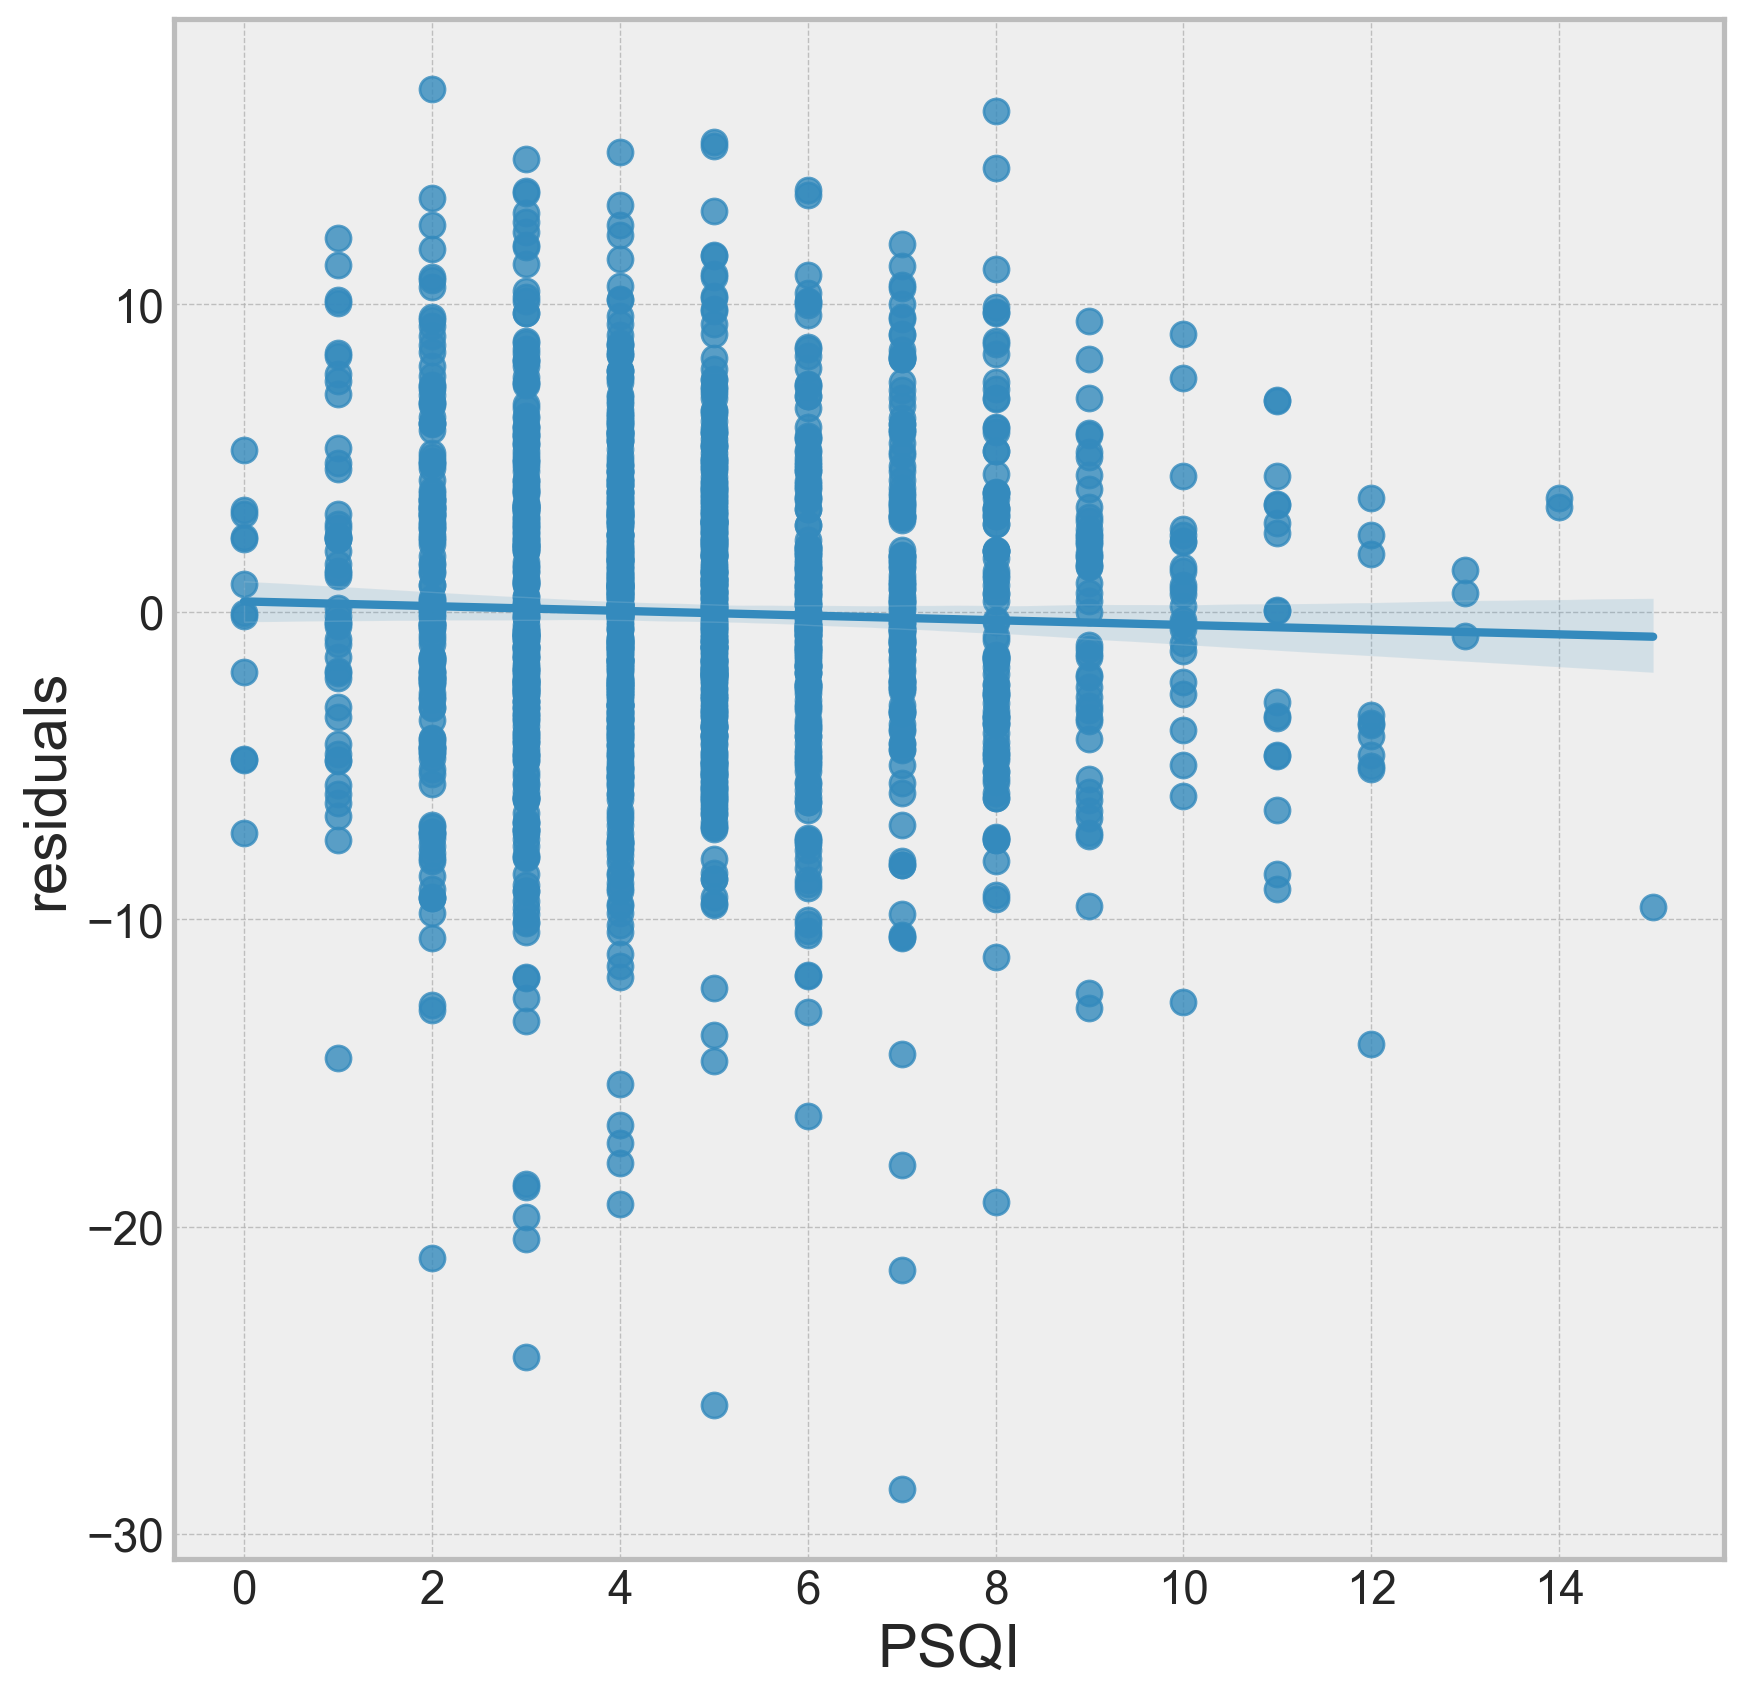

In [50]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=y, y=x, ax=ax)